<!-- Wells Comined 1225 - Bob -->
<p align="center">
  <img src="https://imgur.com/SurCkwl.png" width="800">
</p>

In [3]:
import os
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr
from sklearn.model_selection import cross_validate, KFold
from sklearn.preprocessing import StandardScaler

In [4]:
df = pd.read_csv("../../Dataset/PVT_0782.csv")
df = df.sample(frac=1, random_state=42).reset_index(drop=True)  # 🔀 Shuffle rows

# Preview columns
print(df.columns.tolist())

# Define features and target
X = df.drop(columns=["Pb", "Bob"])
y = df["Pb"]

['Tf', 'Rs', 'gg', 'api ', 'Pb', 'Bob']


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

Training samples: 547
Testing samples: 235


# Linear Regression

In [7]:
from sklearn.linear_model import LinearRegression

# Start timer
start_time = time.time()

# Train Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# End timer
end_time = time.time()

# Compute Training Time
training_time = end_time - start_time

# Predict on test data
y_pred = model.predict(X_test)

# Compute Metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Compute Adjusted R² Score
n = len(y_test)  # Number of samples
p = X_test.shape[1]  # Number of features
adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1))

# Print Results
print(f"Linear Regression Training Time: {training_time:.4f} seconds")
print(f"Linear Regression MSE: {mse:.4f}")
print(f"Linear Regression RMSE: {rmse:.4f}")
print(f"Linear Regression MAE: {mae:.4f}")
print(f"Linear Regression R² Score: {r2:.4f}")
print(f"Linear Regression Adjusted R² Score: {adjusted_r2:.4f}")


Linear Regression Training Time: 0.0007 seconds
Linear Regression MSE: 241249.9562
Linear Regression RMSE: 491.1720
Linear Regression MAE: 384.3707
Linear Regression R² Score: 0.8158
Linear Regression Adjusted R² Score: 0.8126


# Regularized Linear Models - Ridge Best

In [9]:
from sklearn.linear_model import Lasso, Ridge

# Define a range of alpha values
alpha_values = np.logspace(-3, 1, 10)

# Initialize variables to store best results
best_lasso_alpha, best_lasso_score, best_lasso_mse, best_lasso_rmse, best_lasso_mae, best_lasso_r2, best_lasso_adj_r2, best_lasso_time = None, -float('inf'), None, None, None, None, None, None
best_ridge_alpha, best_ridge_score, best_ridge_mse, best_ridge_rmse, best_ridge_mae, best_ridge_r2, best_ridge_adj_r2, best_ridge_time = None, -float('inf'), None, None, None, None, None, None

with tqdm(total=len(alpha_values), desc="Tuning Lasso & Ridge") as pbar:
    for alpha in alpha_values:
        # Lasso
        start_time = time.time()
        lasso_model = Lasso(alpha=alpha)
        lasso_model.fit(X_train, y_train)
        y_pred_lasso = lasso_model.predict(X_test)
        end_time = time.time()

        lasso_mse = mean_squared_error(y_test, y_pred_lasso)
        lasso_rmse = np.sqrt(lasso_mse)
        lasso_mae = mean_absolute_error(y_test, y_pred_lasso)
        lasso_r2 = r2_score(y_test, y_pred_lasso)
        lasso_time = end_time - start_time

        # Compute Adjusted R² Score
        n = len(y_test)
        p = X_test.shape[1]
        if n > p + 1:
            lasso_adjusted_r2 = 1 - ((1 - lasso_r2) * (n - 1) / (n - p - 1))
        else:
            lasso_adjusted_r2 = None

        # Weighted score to balance MSE and performance
        lasso_score = (-0.01 * lasso_mse) + (lasso_r2 * 100)

        if lasso_score > best_lasso_score:
            best_lasso_alpha, best_lasso_score, best_lasso_mse, best_lasso_rmse, best_lasso_mae, best_lasso_r2, best_lasso_adj_r2, best_lasso_time = (
                alpha, lasso_score, lasso_mse, lasso_rmse, lasso_mae, lasso_r2, lasso_adjusted_r2, lasso_time
            )

        # Ridge
        start_time = time.time()
        ridge_model = Ridge(alpha=alpha)
        ridge_model.fit(X_train, y_train)
        y_pred_ridge = ridge_model.predict(X_test)
        end_time = time.time()

        ridge_mse = mean_squared_error(y_test, y_pred_ridge)
        ridge_rmse = np.sqrt(ridge_mse)
        ridge_mae = mean_absolute_error(y_test, y_pred_ridge)
        ridge_r2 = r2_score(y_test, y_pred_ridge)
        ridge_time = end_time - start_time

        # Compute Adjusted R² Score
        if n > p + 1:
            ridge_adjusted_r2 = 1 - ((1 - ridge_r2) * (n - 1) / (n - p - 1))
        else:
            ridge_adjusted_r2 = None

        # Weighted score to balance MSE and performance
        ridge_score = (-0.01 * ridge_mse) + (ridge_r2 * 100)

        if ridge_score > best_ridge_score:
            best_ridge_alpha, best_ridge_score, best_ridge_mse, best_ridge_rmse, best_ridge_mae, best_ridge_r2, best_ridge_adj_r2, best_ridge_time = (
                alpha, ridge_score, ridge_mse, ridge_rmse, ridge_mae, ridge_r2, ridge_adjusted_r2, ridge_time
            )

        pbar.update(1)

# Print best values and times for Lasso & Ridge
print(f"\nBest Lasso Alpha: {best_lasso_alpha}, Best Score: {best_lasso_score:.4f}, Best MSE: {best_lasso_mse:.4f}, "
      f"Best RMSE: {best_lasso_rmse:.4f}, Best MAE: {best_lasso_mae:.4f}, Best R²: {best_lasso_r2:.4f}, "
      f"{f'Best Adjusted R²: {best_lasso_adj_r2:.4f}' if best_lasso_adj_r2 is not None else 'Best Adjusted R²: N/A'}, "
      f"Training Time: {best_lasso_time:.4f}s")

print(f"Best Ridge Alpha: {best_ridge_alpha}, Best Score: {best_ridge_score:.4f}, Best MSE: {best_ridge_mse:.4f}, "
      f"Best RMSE: {best_ridge_rmse:.4f}, Best MAE: {best_ridge_mae:.4f}, Best R²: {best_ridge_r2:.4f}, "
      f"{f'Best Adjusted R²: {best_ridge_adj_r2:.4f}' if best_ridge_adj_r2 is not None else 'Best Adjusted R²: N/A'}, "
      f"Training Time: {best_ridge_time:.4f}s")


Tuning Lasso & Ridge: 100%|████████████████████| 10/10 [00:00<00:00, 520.81it/s]


Best Lasso Alpha: 0.001, Best Score: -2330.9201, Best MSE: 241249.9944, Best RMSE: 491.1721, Best MAE: 384.3711, Best R²: 0.8158, Best Adjusted R²: 0.8126, Training Time: 0.0017s
Best Ridge Alpha: 0.001, Best Score: -2330.9203, Best MSE: 241250.0152, Best RMSE: 491.1721, Best MAE: 384.3713, Best R²: 0.8158, Best Adjusted R²: 0.8126, Training Time: 0.0010s


# Decision Tree

In [11]:
from sklearn.tree import DecisionTreeRegressor

# Define range of max_depth values
max_depth_values = range(1, 21)
best_tree_depth, best_tree_score, best_tree_mse, best_tree_rmse, best_tree_mae, best_tree_r2, best_tree_adj_r2, best_tree_time = None, -float('inf'), None, None, None, None, None, None

with tqdm(total=len(max_depth_values), desc="Tuning Decision Tree") as pbar:
    for depth in max_depth_values:
        start_time = time.time()
        
        # Train Decision Tree model
        tree_model = DecisionTreeRegressor(max_depth=depth, random_state=42)
        tree_model.fit(X_train, y_train)
        y_pred_tree = tree_model.predict(X_test)
        
        end_time = time.time()

        # Compute Metrics
        tree_mse = mean_squared_error(y_test, y_pred_tree)
        tree_rmse = np.sqrt(tree_mse)
        tree_mae = mean_absolute_error(y_test, y_pred_tree)
        tree_r2 = r2_score(y_test, y_pred_tree)
        tree_time = end_time - start_time

        # Compute Adjusted R² Score
        n = len(y_test) 
        p = X_test.shape[1] 
        if n > p + 1:
            tree_adj_r2 = 1 - ((1 - tree_r2) * (n - 1) / (n - p - 1))
            tree_adj_r2 = max(tree_adj_r2, 0)  
        else:
            tree_adj_r2 = None

        # Compute Weighted Score
        tree_score = -tree_mse + (tree_r2 * 100) 

        # Store best results based on score
        if tree_score > best_tree_score:
            best_tree_depth, best_tree_score, best_tree_mse, best_tree_rmse, best_tree_mae, best_tree_r2, best_tree_adj_r2, best_tree_time = (
                depth, tree_score, tree_mse, tree_rmse, tree_mae, tree_r2, tree_adj_r2, tree_time
            )

        pbar.update(1)  # Update progress bar

# Print best values
print(f"\nBest Decision Tree Depth: {best_tree_depth}, Best Score: {best_tree_score:.4f}, Best MSE: {best_tree_mse:.4f}, "
      f"Best RMSE: {best_tree_rmse:.4f}, Best MAE: {best_tree_mae:.4f}, Best R²: {best_tree_r2:.4f}, "
      f"{f'Best Adjusted R²: {best_tree_adj_r2:.4f}' if best_tree_adj_r2 is not None else 'Best Adjusted R²: N/A'}, "
      f"Training Time: {best_tree_time:.4f}s")


Tuning Decision Tree: 100%|████████████████████| 20/20 [00:00<00:00, 669.95it/s]


Best Decision Tree Depth: 4, Best Score: -226779.7320, Best MSE: 226862.4104, Best RMSE: 476.3008, Best MAE: 356.1415, Best R²: 0.8268, Best Adjusted R²: 0.8238, Training Time: 0.0010s


# KNN

In [13]:
from sklearn.neighbors import KNeighborsRegressor

# Tuning KNN
neighbor_values = range(1, 21)
best_knn_k, best_knn_score, best_knn_mse, best_knn_rmse, best_knn_mae, best_knn_r2, best_knn_adj_r2, best_knn_time = None, -float('inf'), None, None, None, None, None, None

with tqdm(total=len(neighbor_values), desc="Tuning KNN") as pbar:
    for k in neighbor_values:
        start_time = time.time()
        knn_model = KNeighborsRegressor(n_neighbors=k)
        knn_model.fit(X_train, y_train)
        y_pred_knn = knn_model.predict(X_test)
        end_time = time.time()

        # Compute Metrics
        knn_mse = mean_squared_error(y_test, y_pred_knn)
        knn_rmse = np.sqrt(knn_mse)
        knn_mae = mean_absolute_error(y_test, y_pred_knn)
        knn_r2 = r2_score(y_test, y_pred_knn)
        knn_time = end_time - start_time

        # Compute Adjusted R² Score
        n = len(y_test)
        p = X_test.shape[1]
        if n > p + 1:
            knn_adjusted_r2 = 1 - ((1 - knn_r2) * (n - 1) / (n - p - 1))
            knn_adjusted_r2 = max(knn_adjusted_r2, 0) 
        else:
            knn_adjusted_r2 = None  # Adjusted R² not valid

        # Compute Weighted Score
        knn_score = -knn_mse + (knn_r2 * 100)  

        # Store best results based on Score
        if knn_score > best_knn_score:
            best_knn_k, best_knn_score, best_knn_mse, best_knn_rmse, best_knn_mae, best_knn_r2, best_knn_adj_r2, best_knn_time = (
                k, knn_score, knn_mse, knn_rmse, knn_mae, knn_r2, knn_adjusted_r2, knn_time
            )

        pbar.update(1)

# Print best values for KNN
print(f"\nBest KNN K: {best_knn_k}, Best Score: {best_knn_score:.4f}, Best MSE: {best_knn_mse:.4f}, "
      f"Best RMSE: {best_knn_rmse:.4f}, Best MAE: {best_knn_mae:.4f}, Best R²: {best_knn_r2:.4f}, "
      f"{f'Best Adjusted R²: {best_knn_adj_r2:.4f}' if best_knn_adj_r2 is not None else 'Best Adjusted R²: N/A'}, "
      f"KNN Training Time: {best_knn_time:.4f}s")


Tuning KNN: 100%|██████████████████████████████| 20/20 [00:00<00:00, 884.68it/s]


Best KNN K: 5, Best Score: -222354.6621, Best MSE: 222437.6783, Best RMSE: 471.6330, Best MAE: 361.2891, Best R²: 0.8302, Best Adjusted R²: 0.8272, KNN Training Time: 0.0007s


# SVR 

In [15]:
from sklearn.svm import SVR

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Tuning SVR
C_values = np.logspace(-3, 2, 10)       
epsilon_values = np.linspace(0.01, 1.0, 5)

best_C, best_epsilon = None, None
best_svr_score = -float('inf')
best_svr_mse, best_svr_rmse, best_svr_mae, best_svr_r2, best_svr_adj_r2, best_svr_time = None, None, None, None, None, None

total_combinations = len(C_values) * len(epsilon_values)
with tqdm(total=total_combinations, desc="Tuning SVR") as pbar:
    for C in C_values:
        for epsilon in epsilon_values:
            start_time = time.time()
            svr_model = SVR(kernel='rbf', C=C, epsilon=epsilon)
            svr_model.fit(X_train_scaled, y_train.values.ravel())
            y_pred_svr = svr_model.predict(X_test_scaled)
            end_time = time.time()

            # Compute Metrics
            svr_mse = mean_squared_error(y_test, y_pred_svr)
            svr_rmse = np.sqrt(svr_mse)
            svr_mae = mean_absolute_error(y_test, y_pred_svr)
            svr_r2 = r2_score(y_test, y_pred_svr)
            svr_time = end_time - start_time

            # Compute Adjusted R² Score
            n = len(y_test)
            p = X_test.shape[1]
            if n > p + 1:
                svr_adjusted_r2 = 1 - ((1 - svr_r2) * (n - 1) / (n - p - 1))
                svr_adjusted_r2 = max(svr_adjusted_r2, 0)  # Prevent large negative values
            else:
                svr_adjusted_r2 = None  # Adjusted R² not valid

            # Compute Weighted Score (Reward high R², penalize high MSE)
            svr_score = -svr_mse + (svr_r2 * 100)

            # Store best results based on Score
            if svr_score > best_svr_score:
                best_C, best_epsilon = C, epsilon
                best_svr_score = svr_score
                best_svr_mse, best_svr_rmse = svr_mse, svr_rmse
                best_svr_mae, best_svr_r2 = svr_mae, svr_r2
                best_svr_adj_r2, best_svr_time = svr_adjusted_r2, svr_time

            pbar.update(1)

final_svr_model = SVR(kernel='rbf', C=best_C, epsilon=best_epsilon)
final_svr_model.fit(X_train_scaled, y_train.values.ravel())
y_pred_svr = final_svr_model.predict(X_test_scaled)

# Print best values for SVR
print(f"\nBest SVR C: {best_C:.4f}, Best Epsilon: {best_epsilon},Best Score: {best_svr_score:.4f}, Best MSE: {best_svr_mse:.4f}, "
      f"Best RMSE: {best_svr_rmse:.4f}, Best MAE: {best_svr_mae:.4f}, Best R²: {best_svr_r2:.4f}, "
      f"{f'Best Adjusted R²: {best_svr_adj_r2:.4f}' if best_svr_adj_r2 is not None else 'Best Adjusted R²: N/A'}, "
      f"Training Time: {best_svr_time:.4f}s")


Tuning SVR: 100%|██████████████████████████████| 50/50 [00:00<00:00, 154.39it/s]


Best SVR C: 100.0000, Best Epsilon: 1.0,Best Score: -211591.5867, Best MSE: 211675.4247, Best RMSE: 460.0820, Best MAE: 320.0870, Best R²: 0.8384, Best Adjusted R²: 0.8356, Training Time: 0.0072s


## MSE, RMSE, MAE Comparisons

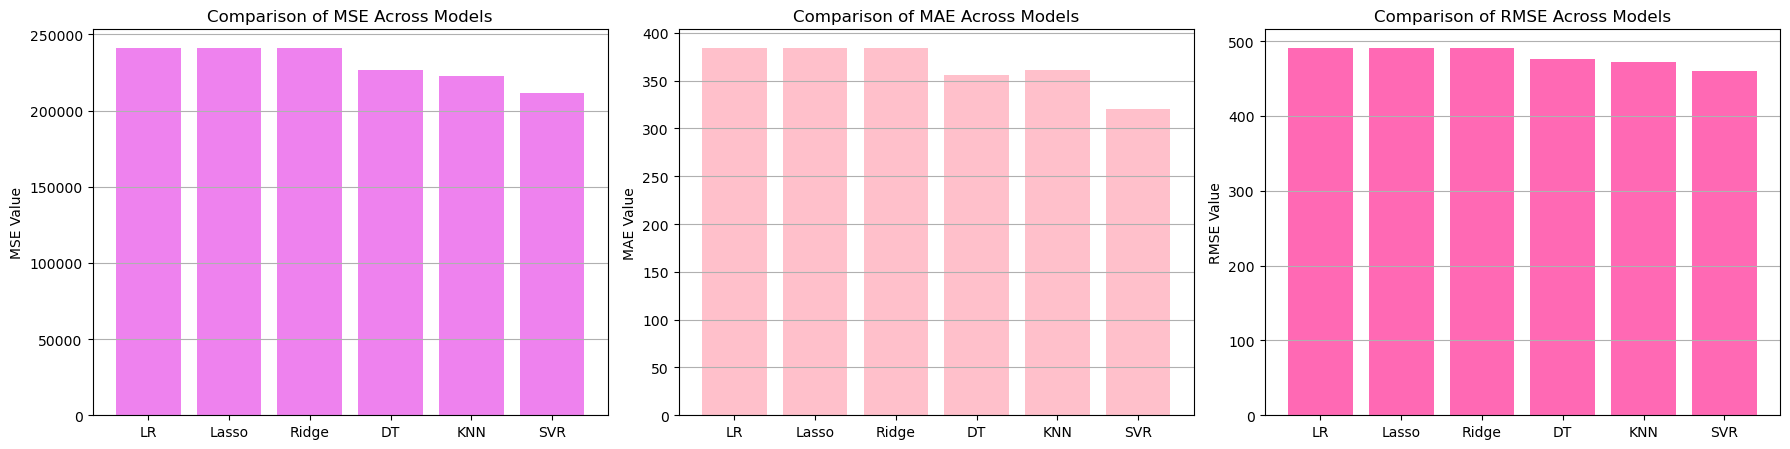

In [17]:
import matplotlib.pyplot as plt

x_labels = ["LR", "Lasso", "Ridge", "DT", "KNN", "SVR"]
mse_values = [mse, best_lasso_mse, best_ridge_mse, best_tree_mse, best_knn_mse, best_svr_mse]
mae_values = [mae, best_lasso_mae, best_ridge_mae, best_tree_mae, best_knn_mae, best_svr_mae]
rmse_values = [rmse, best_lasso_rmse, best_ridge_rmse, best_tree_rmse, best_knn_rmse, best_svr_rmse]

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

axs[0].bar(x_labels, mse_values, color='violet')
axs[0].set_title("Comparison of MSE Across Models")
axs[0].set_ylabel("MSE Value")
axs[0].grid(axis='y')

axs[1].bar(x_labels, mae_values, color='pink')
axs[1].set_title("Comparison of MAE Across Models")
axs[1].set_ylabel("MAE Value")
axs[1].grid(axis='y')

axs[2].bar(x_labels, rmse_values, color='hotpink')
axs[2].set_title("Comparison of RMSE Across Models")
axs[2].set_ylabel("RMSE Value")
axs[2].grid(axis='y')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## R$^{2}$ & R$^{2}$ Adjusted  Comparisons

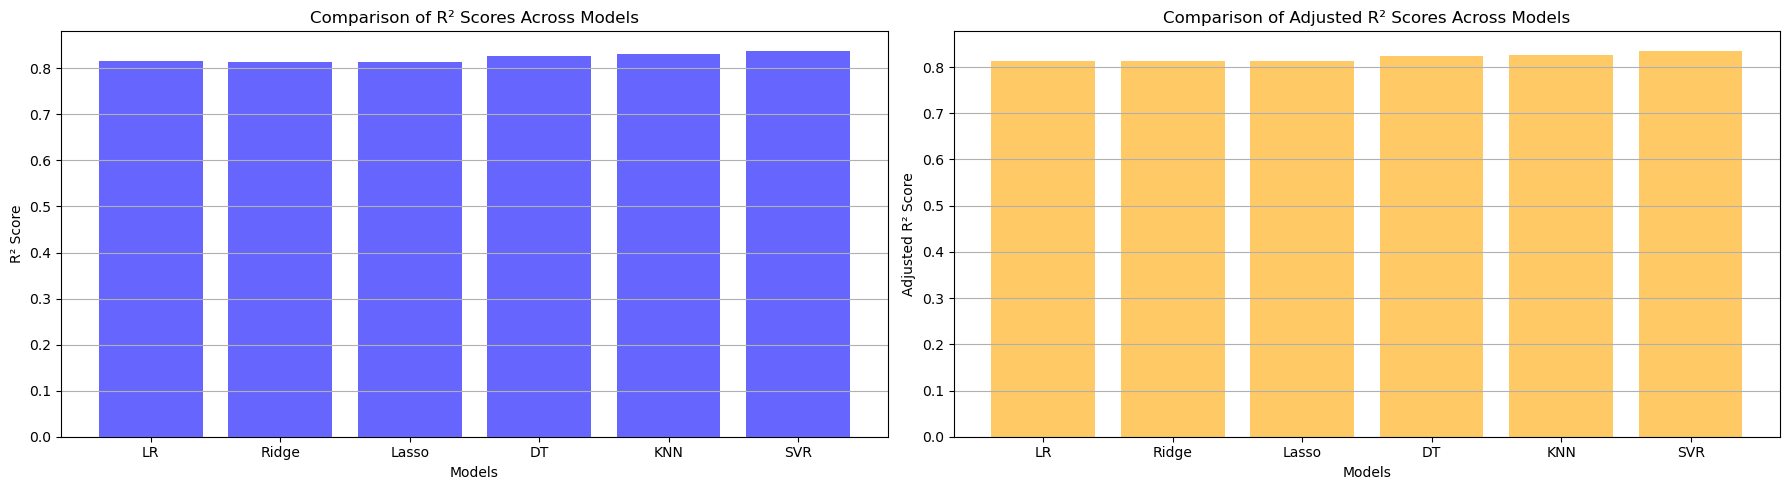

In [19]:
# Define x labels for models
x_labels = ["LR", "Ridge", "Lasso" ,"DT", "KNN", "SVR"]

# Define y values for R² and Adjusted R² 
r2_values = [r2, ridge_r2,lasso_r2, best_tree_r2, best_knn_r2, best_svr_r2]
adjusted_r2_values = [val if val is not None else 0 for val in [adjusted_r2, best_ridge_adj_r2, best_lasso_adj_r2, best_tree_adj_r2, best_knn_adj_r2, best_svr_adj_r2]]

plt.style.use('default')

fig, axs = plt.subplots(1, 2, figsize=(18, 5))

# Plot R² Scores
axs[0].bar(x_labels, r2_values, color='blue', alpha=0.6)
axs[0].set_title("Comparison of R² Scores Across Models")
axs[0].set_xlabel("Models")
axs[0].set_ylabel("R² Score")
axs[0].grid(axis='y')

# Plot Adjusted R² Scores
axs[1].bar(x_labels, adjusted_r2_values, color='orange', alpha=0.6)
axs[1].set_title("Comparison of Adjusted R² Scores Across Models")
axs[1].set_xlabel("Models")
axs[1].set_ylabel("Adjusted R² Score")
axs[1].grid(axis='y')

plt.tight_layout()
plt.show()

------------------------------

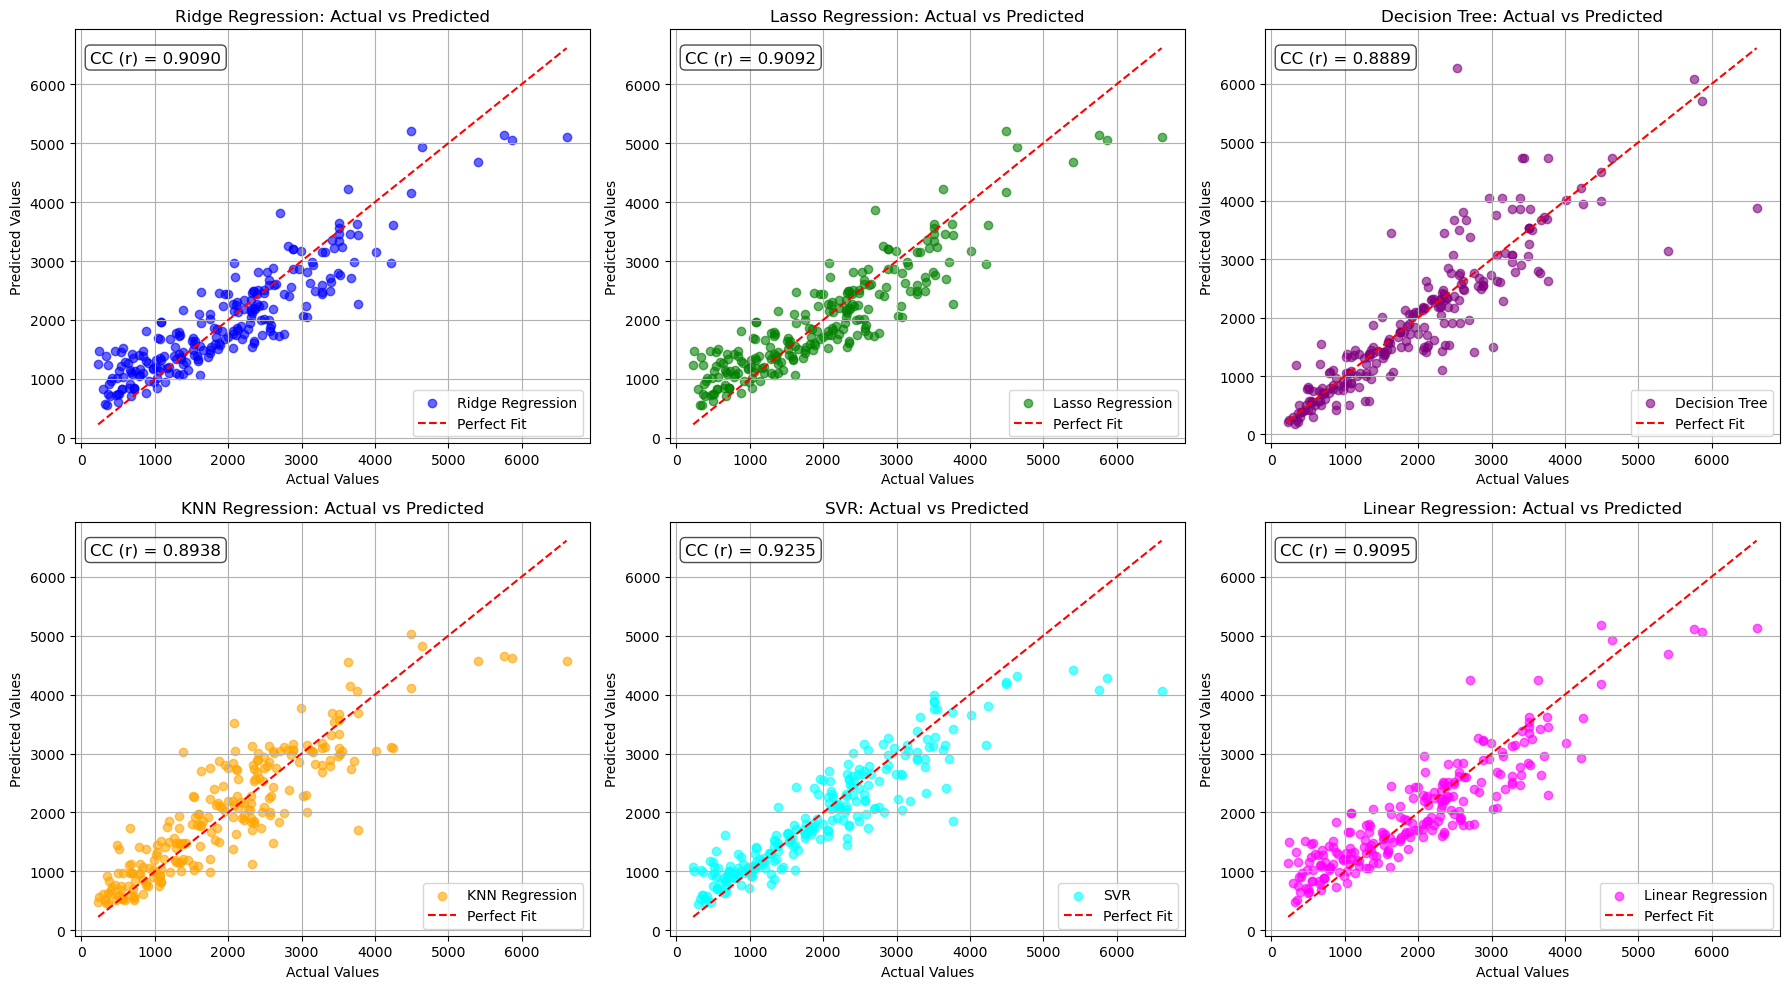

In [38]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()
plot_index = 0  

def plot_actual_vs_predicted(y_test, y_pred, model_name, color):
    global plot_index  # Use the shared subplot index
    y_test = np.array(y_test).flatten()
    y_pred = np.array(y_pred).flatten()

    # Compute correlation coefficient (Pearson's r)
    cc, _ = pearsonr(y_test, y_pred)

    # Plot on the current subplot
    ax = axes[plot_index]
    ax.scatter(y_test, y_pred, color=color, alpha=0.6, label=f"{model_name}")
    ax.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label="Perfect Fit")

    ax.text(0.03, 0.95, f"CC (r) = {cc:.4f}", transform=ax.transAxes,
             fontsize=12, verticalalignment='top', bbox=dict(boxstyle="round", facecolor="white", alpha=0.7))

    # Labels and title
    ax.set_xlabel("Actual Values")
    ax.set_ylabel("Predicted Values")
    ax.set_title(f"{model_name}: Actual vs Predicted")
    ax.legend(loc='lower right')
    ax.grid(True)

    plot_index += 1  

plot_actual_vs_predicted(y_test, y_pred_ridge, "Ridge Regression", "blue")
plot_actual_vs_predicted(y_test, y_pred_lasso, "Lasso Regression", "green")
plot_actual_vs_predicted(y_test, y_pred_tree, "Decision Tree", "purple")
plot_actual_vs_predicted(y_test, y_pred_knn, "KNN Regression", "orange")
plot_actual_vs_predicted(y_test, y_pred_svr, "SVR", "cyan")
plot_actual_vs_predicted(y_test, y_pred, "Linear Regression", "magenta")

plt.tight_layout()
plt.show()

# 5-Fold Cross-Validation Summary

In [23]:
# Use best hyperparameters from earlier tuning
models = {
    "Linear": LinearRegression(),
    "Ridge": Ridge(alpha=best_ridge_alpha),
    "Lasso": Lasso(alpha=best_lasso_alpha),
    "Decision Tree": DecisionTreeRegressor(max_depth=10),
    "KNN": KNeighborsRegressor(n_neighbors=best_knn_k),
    "SVR": SVR(C=best_C, epsilon=best_epsilon, kernel="rbf")
}

# Cross-validation setup
cv = KFold(n_splits=5, shuffle=True, random_state=42)

results = []

for name, model in models.items():
    cv_scores = cross_validate(
        model, X, y.values.ravel(),
        scoring=['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'],
        cv=cv, return_train_score=False
    )
    
    rmse = np.sqrt(-cv_scores['test_neg_mean_squared_error'])
    mae = -cv_scores['test_neg_mean_absolute_error']
    r2 = cv_scores['test_r2']
    
    results.append({
        "Model": name,
        "RMSE Mean": rmse.mean(),
        "RMSE Std": rmse.std(),
        "MAE Mean": mae.mean(),
        "MAE Std": mae.std(),
        "R² Mean": r2.mean(),
        "R² Std": r2.std()
    })

# Create results table
cv_df = pd.DataFrame(results).sort_values(by="RMSE Mean")
pd.set_option('display.expand_frame_repr', False)
print("\n📊 5-Fold Cross-Validation Summary:")
print(cv_df)


📊 5-Fold Cross-Validation Summary:
           Model   RMSE Mean    RMSE Std    MAE Mean    MAE Std   R² Mean    R² Std
3  Decision Tree  517.155712   66.522680  322.228756  44.435267  0.832579  0.037565
4            KNN  553.230187   71.476196  393.793594  39.812395  0.812588  0.008331
1          Ridge  586.661757  106.673391  405.939157  34.802506  0.790425  0.031644
2          Lasso  586.661863  106.673357  405.939110  34.802493  0.790425  0.031644
0         Linear  586.661987  106.673302  405.938958  34.802438  0.790425  0.031644
5            SVR  651.202189  138.506605  450.288793  70.779622  0.741308  0.057246


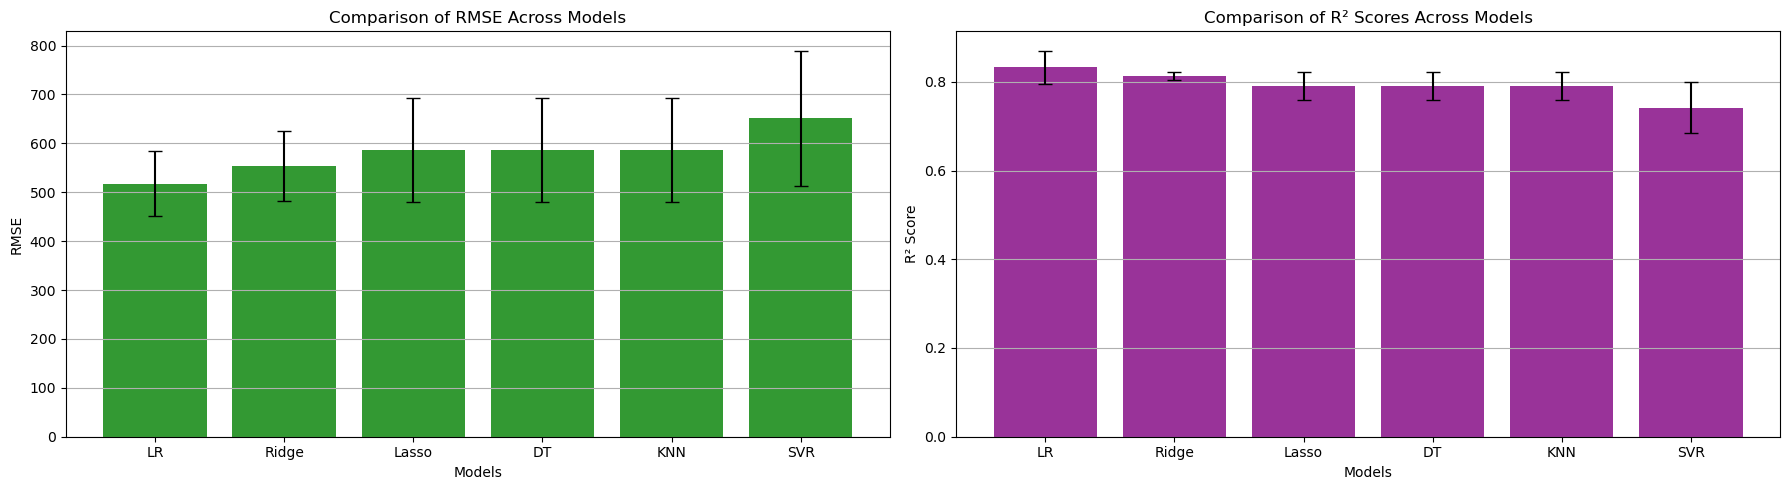

In [24]:
x_labels = ["LR", "Ridge", "Lasso", "DT", "KNN", "SVR"]

# Pull values from cv_df in the correct order
rmse_values = cv_df["RMSE Mean"].values
rmse_std = cv_df["RMSE Std"].values
r2_values = cv_df["R² Mean"].values
r2_std = cv_df["R² Std"].values

# Set up side-by-side bar plots
plt.style.use('default')
fig, axs = plt.subplots(1, 2, figsize=(18, 5))

# Plot RMSE
axs[0].bar(x_labels, rmse_values, yerr=rmse_std, capsize=5, color='green', alpha=0.8)
axs[0].set_title("Comparison of RMSE Across Models")
axs[0].set_xlabel("Models")
axs[0].set_ylabel("RMSE")
axs[0].grid(axis='y')

# Plot R²
axs[1].bar(x_labels, r2_values, yerr=r2_std, capsize=5, color='purple', alpha=0.8)
axs[1].set_title("Comparison of R² Scores Across Models")
axs[1].set_xlabel("Models")
axs[1].set_ylabel("R² Score")
axs[1].grid(axis='y')

plt.tight_layout()
plt.show()